In [1]:
import numpy as np 
import pandas as pd 
import cv2 
import os 
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [2]:
import pathlib
data_dir=pathlib.Path('/kaggle/input/melenoma-cnn-dataset/Skin cancer ISIC The International Skin Imaging Collaboration')

In [8]:
def laod_images_opencv_extisions(path):
    ext = [".jpg",".gif",".png",".tga",".webp"]
    files = []
    images = []
    [files.extend(data_dir.glob(path + '/*' + e)) for e in ext]
    return files

In [5]:

classes= [i.split('\\')[-1] for i in [x[0] for x in os.walk(str(data_dir)+'\Train')][1:]]
classes

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [6]:
len(classes)

9

In [9]:
image_dir={}
for i in classes:
    image_dir[i]=laod_images_opencv_extisions('Train\\'+i)
image_dir

{'actinic keratosis': [WindowsPath('data/Train/actinic keratosis/ISIC_0025780.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0025803.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0025825.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0025953.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0025957.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0025992.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026040.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026149.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026171.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026194.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026212.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026457.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026468.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026525.jpg'),
  WindowsPath('data/Train/actinic keratosis/ISIC_0026575.jpg'),
  WindowsPath('data

In [10]:
test_dir={}
for i in classes:
    test_dir[i]=laod_images_opencv_extisions('Test\\'+i)
test_dir

{'actinic keratosis': [WindowsPath('data/Test/actinic keratosis/ISIC_0010512.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0010889.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024468.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024470.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024511.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024646.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024654.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024707.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024763.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024771.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024800.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024913.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0024948.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0025368.jpg'),
  WindowsPath('data/Test/actinic keratosis/ISIC_0025427.jpg'),
  WindowsPath('data/Test/actinic k

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
def get_dataFrame(dic):
    x,y=[],[]
    for imageName, imagePaths in dic.items():
        for img in imagePaths:
            try:
                x.append(img)
                y.append(imageName)
            except:
                continue 
            
    dataFrame = pd.DataFrame({
        'filename': x,
        'category': y
    })
    dataFrame['category'] = dataFrame['category']
    le=LabelEncoder()
    dataFrame['category']=le.fit_transform(dataFrame['category'])
    dataFrame['category'] = dataFrame['category'].astype('string')
    dataFrame['filename'] = dataFrame['filename'].astype('string')
    dataFrame=dataFrame.sample(frac=1)
    #dataFrame= dataFrame.reset_index()
    return dataFrame

In [12]:
train_data_frame=pd.DataFrame(get_dataFrame(image_dir))
train_data_frame=train_data_frame.reset_index()
train_data_frame.head()

,index,filename,category
0,1243,data\Train\nevus\ISIC_0000473.jpg,4
1,1345,data\Train\nevus\ISIC_0027334.jpg,4
2,71,data\Train\actinic keratosis\ISIC_0029930.jpg,0
3,410,data\Train\basal cell carcinoma\ISIC_0030261.jpg,1
4,672,data\Train\melanoma\ISIC_0000428.jpg,3


In [13]:
test_data_frame=pd.DataFrame(get_dataFrame(test_dir))
test_data_frame=test_data_frame.reset_index()
test_data_frame.head()

,index,filename,category
0,104,data\Test\squamous cell carcinoma\ISIC_0024329...,7
1,105,data\Test\squamous cell carcinoma\ISIC_0024372...,7
2,75,data\Test\nevus\ISIC_0000014.jpg,4
3,84,data\Test\pigmented benign keratosis\ISIC_0024...,5
4,40,data\Test\dermatofibroma\ISIC_0024330.jpg,2


In [14]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(train_data_frame,random_state=10, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [15]:
image_size = 224
input_shape = (image_size, image_size, 3)

batch_size = 16

In [16]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
   
    x_col='filename',
    y_col='category',

    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 1791 validated image filenames belonging to 9 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
     
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    batch_size=batch_size
)


Found 448 validated image filenames belonging to 9 classes.


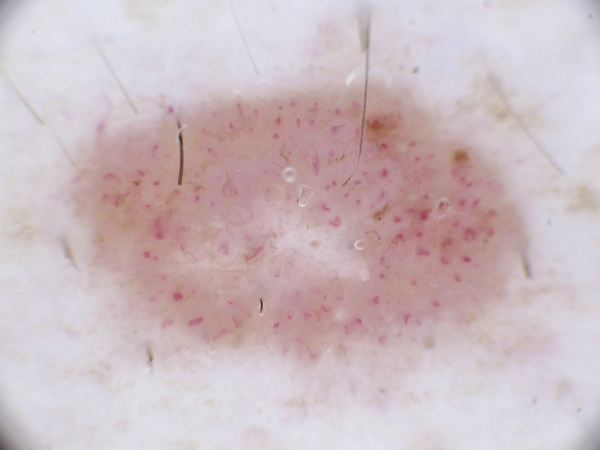

In [18]:
import PIL
PIL.Image.open(str(train_data_frame['filename'][1]))

Found 1 validated image filenames belonging to 1 classes.


C:\Users\MAHMOU~1.ABD\AppData\Local\Temp/ipykernel_18936/2871830971.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


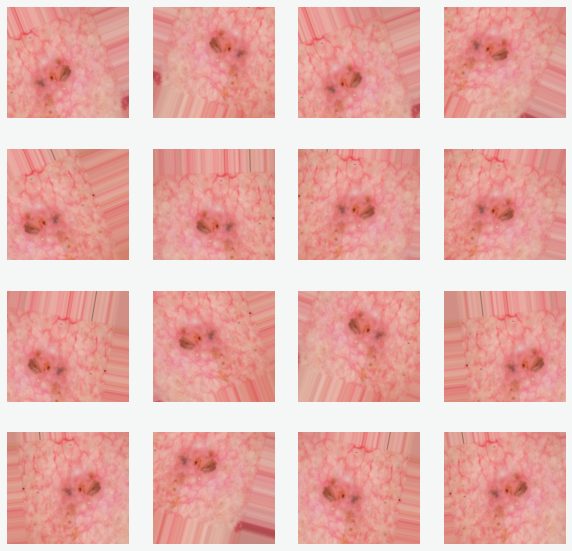

In [19]:
import matplotlib.pyplot as plt
def data_argumentation_show(n, grid_size):

    sample_data = train_datagen.flow_from_dataframe(
            (train_df.sample(n)),
            x_col = 'filename',
            y_col = 'category',
            target_size = (224, 244),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()
data_argumentation_show(1,4)
